In [1]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import itertools
import scipy
import scanpy as sc

import utils as ut

In [2]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/WATAtlas/subtypes/"

fpaths = [
    # "neutrophil_rna.parquet",
    # "epithelial_cell_rna.parquet",
    "macrophage_rna.parquet",
    "immature_NK_T_cell_rna.parquet",
    # "endothelial_cell_of_lymphatic_vessel_rna.parquet",
    # "fat_cell_rna.parquet",
    # "mast_cell_rna.parquet",
    "B_cell_rna.parquet",
    "monocyte_rna.parquet",
    # "mesothelial_cell_rna.parquet",
    # "endothelial_cell_rna.parquet",
    "dendritic_cell_rna.parquet",
    # "mammary_gland_epithelial_cell_rna.parquet",
    "T_cell_rna.parquet",
    # "pericyte_cell_rna.parquet",
    # "smooth_muscle_cell_rna.parquet",
    "preadipocyte_rna.parquet",
]

data = {}
labels = {}
cellTypes= []

for f in fpaths:
    cellKey = f.replace("_rna.parquet", "")
    cellTypes.append(cellKey)
    
    rnaPath = f"{dirpath}{f}"
    labelPath = f"{dirpath}{cellKey}_labels.parquet"
    
    rdf = pd.read_parquet(rnaPath)
    ldf = pd.read_parquet(labelPath)
    
    rdf = ut.normalize(rdf, 1e6)
    
    data[cellKey] = rdf
    labels[cellKey] = ldf
    
    print(f"{cellKey} {rdf.shape=} {ldf.shape=}")
    
print('done')

macrophage rdf.shape=(35876, 23313) ldf.shape=(35876, 58)
immature_NK_T_cell rdf.shape=(228, 23313) ldf.shape=(228, 58)
B_cell rdf.shape=(490, 23313) ldf.shape=(490, 58)
monocyte rdf.shape=(2895, 23313) ldf.shape=(2895, 58)
dendritic_cell rdf.shape=(734, 23313) ldf.shape=(734, 58)
T_cell rdf.shape=(498, 23313) ldf.shape=(498, 58)
preadipocyte rdf.shape=(10945, 23313) ldf.shape=(10945, 58)
done


In [3]:
# build the aggregate expression dataframe 

edf = {}

for ct in cellTypes:
    ldf = labels[ct]
    rdf = data[ct]
    
    for diet in ldf['diet__type'].unique():
        dietKey = "_".join(diet.split(" "))
        cids = ldf[ldf['diet__type'] == diet]['cell_id'].to_list()
        cdf = rdf[rdf.index.isin(cids)]
        print(ct, dietKey, cdf.shape)
        
        # compute the mean expression profile
        cdf = cdf.mean(axis=0)
        columnName = f"{ct}_{dietKey}"
        edf[columnName] = cdf.values

    
edf = pd.DataFrame(edf, index=rdf.columns)
edf.head()

macrophage high_fat_diet (33464, 23313)
macrophage normal_chow_diet (2412, 23313)
immature_NK_T_cell high_fat_diet (146, 23313)
immature_NK_T_cell normal_chow_diet (82, 23313)
B_cell high_fat_diet (321, 23313)
B_cell normal_chow_diet (169, 23313)
monocyte high_fat_diet (2211, 23313)
monocyte normal_chow_diet (684, 23313)
dendritic_cell high_fat_diet (569, 23313)
dendritic_cell normal_chow_diet (165, 23313)
T_cell high_fat_diet (299, 23313)
T_cell normal_chow_diet (199, 23313)
preadipocyte high_fat_diet (5485, 23313)
preadipocyte normal_chow_diet (5460, 23313)


,macrophage_high_fat_diet,macrophage_normal_chow_diet,immature_NK_T_cell_high_fat_diet,immature_NK_T_cell_normal_chow_diet,B_cell_high_fat_diet,B_cell_normal_chow_diet,monocyte_high_fat_diet,monocyte_normal_chow_diet,dendritic_cell_high_fat_diet,dendritic_cell_normal_chow_diet,T_cell_high_fat_diet,T_cell_normal_chow_diet,preadipocyte_high_fat_diet,preadipocyte_normal_chow_diet
0610005C13RIK,4.777090,0.186750,1.270273,0.000000,2.811611,1.989630,2.922356,1.040561,5.584269,2.137143,12.766765,0.754637,3.097895,0.105924
0610006L08RIK,0.017029,0.000000,0.000000,0.000000,0.000000,0.000000,0.284125,0.453189,0.000000,0.000000,0.000000,0.000000,0.160572,0.077076
0610009B22RIK,10.291757,3.373974,0.000000,0.000000,0.628204,0.000000,7.502786,0.494082,5.913654,0.000000,0.744210,0.000000,5.851724,0.418945
0610009O20RIK,18.879202,16.408695,35.458294,12.769762,13.057742,47.434113,18.875546,17.658562,22.359316,18.453310,19.237309,30.593319,24.338966,28.319740
0610010F05RIK,82.334549,91.335533,73.865135,7.311224,34.333225,20.271893,75.812386,91.216675,44.578766,46.534626,38.229099,16.962700,67.761749,101.490250


In [4]:
""" Load our data """

annPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/_global_clusters.csv"
adf = pd.read_csv(annPath)

print(f"{adf.shape=}")
print()
print(adf['sampleInfo'].value_counts())

adf.head()
 

adf.shape=(13820, 4)

HFD14    6436
HFD8     6123
ND       1261
Name: sampleInfo, dtype: int64


,Unnamed: 0,cellId,cellType,sampleInfo
0,0,AAACGAACAGCAGTAG.1_ND,B cells,ND
1,1,AAAGAACGTCTACAGT.1_ND,Mac1,ND
2,2,AAAGAACTCCTCGCAT.1_ND,Mac1,ND
3,3,AAAGGGCGTTAGGGTG.1_ND,Mac3,ND
4,4,AACAAAGAGTATAGGT.1_ND,Monocytes,ND


In [5]:
rnaPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/_global_rna.csv"
rdf = pd.read_csv(rnaPath)
rdf = rdf.rename(columns={'Unnamed: 0' : 'gene'})
rdf = rdf.set_index('gene')
rdf = rdf.T

# filter and ensure that the ordering is the same
pdf = rdf[edf.index]
pdf = ut.normalize(pdf, 1e6)

pdf.head()

gene,0610005C13RIK,0610006L08RIK,0610009B22RIK,0610009O20RIK,0610010F05RIK,0610010K14RIK,0610012D04RIK,0610012G03RIK,0610025J13RIK,0610030E20RIK,...,GM45843,PRM2,WFDC16,ZFP648,CMTM2A,GM14967,GM15156,RNASE2B,GM12343,GM28231
AAACGAACAGCAGTAG.1_ND,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGAACGTCTACAGT.1_ND,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGAACTCCTCGCAT.1_ND,0.0,0.0,0.000000,0.0,221.190002,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGGCGTTAGGGTG.1_ND,0.0,0.0,112.082493,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACAAAGAGTATAGGT.1_ND,0.0,0.0,0.000000,0.0,99.820323,0.0,0.0,99.820323,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
## make sure that the sort is the same 
print(pdf.columns[0])
print(edf.index[0])

0610005C13RIK
0610005C13RIK


In [7]:
# subset the genes we're using 
# gets genes expressed in at least t % of the population
# t = 0.01
# nExp = pdf.astype(bool).sum(axis=0)
# print(f"{nExp.shape=}")
# nExp = nExp / pdf.shape[0]

# genes = nExp[nExp > t]
# print(f"{genes.shape=}")


# or use the most variable genes
q = 50
var = pdf.std(axis=0)

genes = var[var > np.percentile(var, q)]
print(f"{genes.shape=}")

genes.shape=(11656,)


In [8]:
metric = 'correlation'

hdf = edf.T
hdf[genes.index] = sklearn.preprocessing.minmax_scale(hdf[genes.index], feature_range=(0, 1), axis=1)

res = []

# for key in ['ND', 'HFD8', 'HFD14']:
for key in ['ND', 'HFD8', 'HFD14']:
    kdf = adf[adf['sampleInfo'] == key]
    
    for cellType in adf['cellType'].unique():
        cids = kdf[kdf['cellType'] == cellType]['cellId']
        cx = pdf[pdf.index.isin(cids)].reset_index(drop=False)
        cx[genes.index] = sklearn.preprocessing.minmax_scale(cx[genes.index], feature_range=(0, 1), axis=1)
         
        cx= cx.set_index('index')    
        dist = scipy.spatial.distance.cdist(cx, hdf, metric)
        
        dist = pd.DataFrame(dist, columns=edf.columns)
        dist['cellType'] = cellType
        dist['key'] = key
        res.append(dist)
        print(f"{cellType} {key} {len(cids)=} {cx.shape} {dist.shape=}")
        

res = pd.concat(res)
print(res.shape)
res.head()

B cells ND len(cids)=362 (362, 23313) dist.shape=(362, 16)
Mac1 ND len(cids)=136 (136, 23313) dist.shape=(136, 16)
Mac3 ND len(cids)=179 (179, 23313) dist.shape=(179, 16)
Monocytes ND len(cids)=175 (175, 23313) dist.shape=(175, 16)
T cells ND len(cids)=93 (93, 23313) dist.shape=(93, 16)
NK cells ND len(cids)=96 (96, 23313) dist.shape=(96, 16)
Stromal cells ND len(cids)=33 (33, 23313) dist.shape=(33, 16)
Dendritic cells ND len(cids)=143 (143, 23313) dist.shape=(143, 16)
Mac4 ND len(cids)=15 (15, 23313) dist.shape=(15, 16)
Mac2 ND len(cids)=25 (25, 23313) dist.shape=(25, 16)
Mac5 ND len(cids)=4 (4, 23313) dist.shape=(4, 16)
B cells HFD8 len(cids)=282 (282, 23313) dist.shape=(282, 16)
Mac1 HFD8 len(cids)=317 (317, 23313) dist.shape=(317, 16)
Mac3 HFD8 len(cids)=519 (519, 23313) dist.shape=(519, 16)
Monocytes HFD8 len(cids)=714 (714, 23313) dist.shape=(714, 16)
T cells HFD8 len(cids)=1298 (1298, 23313) dist.shape=(1298, 16)
NK cells HFD8 len(cids)=505 (505, 23313) dist.shape=(505, 16)
Stro

,macrophage_high_fat_diet,macrophage_normal_chow_diet,immature_NK_T_cell_high_fat_diet,immature_NK_T_cell_normal_chow_diet,B_cell_high_fat_diet,B_cell_normal_chow_diet,monocyte_high_fat_diet,monocyte_normal_chow_diet,dendritic_cell_high_fat_diet,dendritic_cell_normal_chow_diet,T_cell_high_fat_diet,T_cell_normal_chow_diet,preadipocyte_high_fat_diet,preadipocyte_normal_chow_diet,cellType,key
0,1.000610,1.000347,0.992742,0.993684,0.979252,0.991067,1.000298,1.000112,1.000453,0.998444,0.981188,0.994277,1.000492,1.001307,B cells,ND
1,1.000420,1.000636,1.000269,1.001000,0.999331,0.998434,1.000578,1.000495,1.000349,1.000895,1.000683,0.997150,1.001304,1.001223,B cells,ND
2,1.000672,0.999824,0.996310,0.989486,0.986554,0.968902,1.000706,0.997355,0.998987,0.995122,0.999191,0.989965,1.000651,1.000243,B cells,ND
3,0.999918,1.000509,0.999294,0.999594,1.000491,0.997354,1.000204,1.000171,1.000341,0.996079,1.000537,0.999389,1.000418,1.000200,B cells,ND
4,0.990991,0.991058,0.998729,1.001009,0.990825,0.994848,0.995052,0.999539,0.999822,1.001336,1.000553,1.001106,0.998580,1.000354,B cells,ND


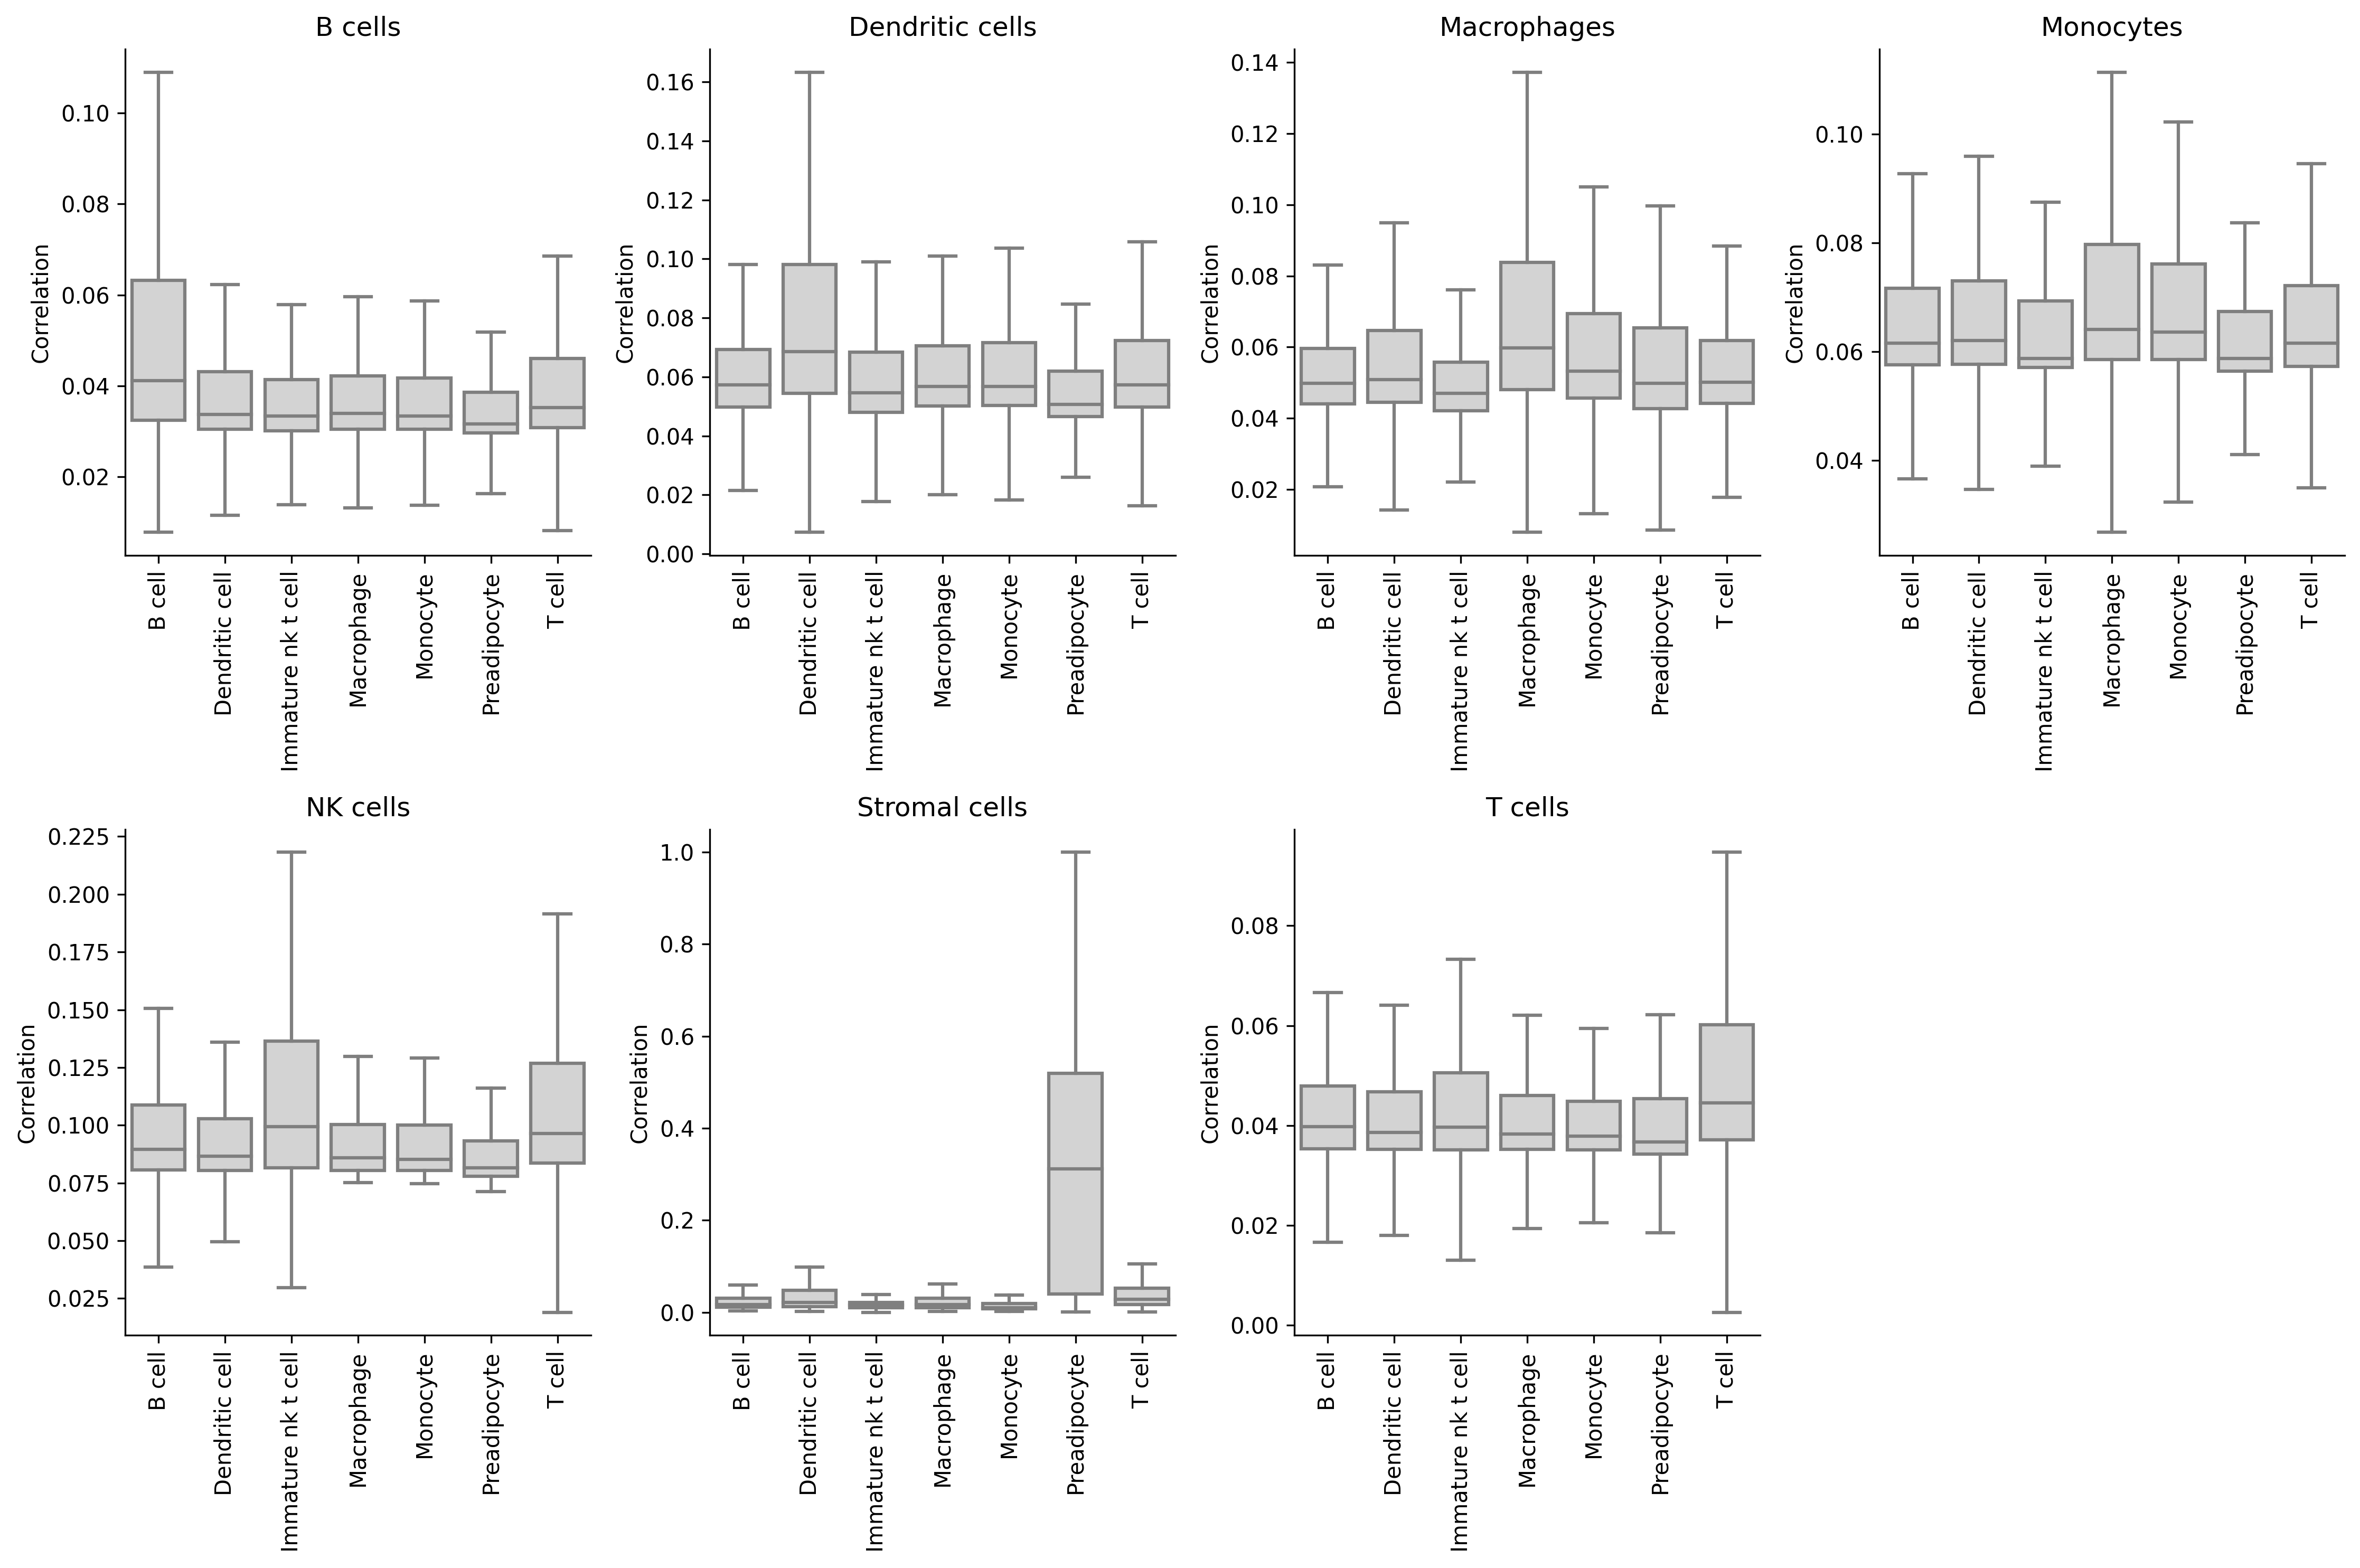

In [12]:
pxf = res.copy()
pxf = pd.melt(pxf, id_vars=['cellType', 'key'])
pxf['corr'] = 1- pxf['value']

pxf['diet'] = np.where(pxf['variable'].str.contains('high'), "HFD", "ND")
pxf['cellComp'] = pxf['variable'].str.replace("_high_fat_diet", "")
pxf['cellComp'] = pxf['cellComp'].str.replace("_normal_chow_diet", "")
pxf['cellComp'] = pxf['cellComp'].apply(lambda x: " ".join(x.split("_")).capitalize())

pxf['metaType'] = np.where(pxf['cellType'].str.contains('Mac'), 'Macrophages', pxf['cellType'])

pxf['keyName'] = pxf['key'].map({"ND": "ND", "HFD8" : "8w", "HFD14" : "14w"})
mask = (pxf['diet'] == "ND")

pxf = pxf.sort_values(by=['key', 'metaType', 'cellComp', 'diet'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 10

fig, axs = plt.subplots(2, 4)
axs = axs.ravel()

for i, ct in enumerate(sorted(pxf['metaType'].unique())):
    
    cxf = pxf[pxf['metaType'] == ct].reset_index()
    cxf['corrNorm'] = sklearn.preprocessing.minmax_scale(cxf['corr'], feature_range=(0, 1))
    sns.boxplot(data=cxf,
                x='cellComp',
                y='corrNorm',
                color='lightgrey',
                # hue='keyName',
                showfliers=False,
                ax=axs[i])
    
    axs[i].set_title(f"{ct}")
    axs[i].set_ylabel("Correlation")
    axs[i].set_xlabel("")

    # axs[i].set_yscale("log")
    axs[i].tick_params(axis='x', rotation=90)
                
    # break

axs[7].axis(False)    # remove last axis
sns.despine()
plt.tight_layout()

In [10]:
pxf['cellType'].nunique()

11

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
print(pdf.columns[0])
print(df.columns[0])

In [ ]:
pxf = pd.DataFrame(dist, index=pdf.index)

pxf = pd.merge(pxf, ldf[['cellId', 'sampleInfo']],
               how='left',
               left_index=True,
               right_on='cellId')

pxf = pd.melt(pxf, id_vars=['cellId', 'sampleInfo'])


pxf.head()


sns.boxplot(data=pxf, 
            x='sampleInfo',
            showfliers=False,
            y='value')

In [ ]:
# cdf = pd.concat([pdf, df])
# print(cdf.shape)



In [ ]:
mdf.columns

In [ ]:
mdf['fat__type'].value_counts()